# Kyle Calabro
# DATA 750 - Thesis in Data Science
---

# Notebook Six w/ Filtered Images:
---
## Deploy transfer learning models for feature extraction on the original  training data, evaluate performance on testing with grayscale images and contrast stretching.

In [ ]:
!pip install fsspec
!pip install gcsfs

import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from PIL import Image
from skimage import exposure, img_as_float

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

     |████████████████████████████████| 125 kB 5.6 MB/s 
     |████████████████████████████████| 1.3 MB 8.3 MB/s 
     |████████████████████████████████| 160 kB 65.8 MB/s 
     |████████████████████████████████| 271 kB 57.4 MB/s 


In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'quantum-bonus-330300'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'kpc_thesis'

Updated property [core/project].
gs://kpc_thesis/


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.79.236.50:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.79.236.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.236.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Utility Functions
---

In [ ]:
# Extracts features from images to save time in model training
# Params:
    # model: The model to predict with
    # input_imgs: set of images to gather features from
    
def get_bneck_features(model, input_ds):
    features = model.predict(input_ds, verbose = 0)
    return features

In [ ]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [ ]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [ ]:
# To get the predicted labels of a given CNN model
# Params:
    # test_dataset: tf.data dataset containing image tensors and corresponding labels
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(test_dataset, model, encoder):
    y_pred = model.predict(test_dataset)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [ ]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [ ]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

In [ ]:
# To load an image from a Google Cloud Storage Bucket and convert to grayscale
# adjusting the contrast by a factor of two

# Params:
  # path: path to the image in the GCS bucket
  # label: the label corresponding to the image given by the path

def load_gs_f2_images(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  image = tf.image.adjust_contrast(image, 2)
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

# Bringing in the Data
----

In [ ]:
regex = re.compile(r"\d+")

In [ ]:
# Generate list of files containing the training images from the bucket
train_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Train/*.jpeg")

# Get the metadata of the images
train_metadata = pd.read_csv("gs://kpc_thesis/Orig_Train/orig_train_data.csv")
train_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in train_files]
index_list = list(map(int, index_list))

train_labels = [train_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
# Generate list of files containing the test images from the bucket
test_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Test/*.jpeg")

# Get the metadata of the images
test_metadata = pd.read_csv("gs://kpc_thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
print("Number of Training Labels:", len(train_labels))

Number of Training Labels: 1152


In [ ]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [ ]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(train_labels))
y_test = to_categorical(encoder.fit_transform(test_labels))

In [ ]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [ ]:
# Create TF datasets from the images and corresponding labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, y_test))

In [ ]:
train_dataset = (train_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
train_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
test_dataset = (test_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
test_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
# Define the input shape of the image tensors for the network
input_shape_orig = (217, 334, 3)

# VGG-16 Model Deployment as Feature Extractor
---

In [ ]:
def create_model():
  vgg = vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_model = Model(vgg.input, output)

  vgg_model.trainable = False

  for layer in vgg_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_model.output_shape[1]

  vgg_train_features = get_bneck_features(vgg_model, train_dataset)
  vgg_test_features = get_bneck_features(vgg_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, vgg_train_features, vgg_test_features

with tpu_strategy.scope():
  model, vgg_train_features, vgg_test_features = create_model()
  model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 15,995,912
Trainable params: 15,995,912
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Layers of the VGG-16 model are frozen, weights will not change during training

In [ ]:
print("Training Set Bottleneck Features:", vgg_train_features.shape)
print("Test Set Bottleneck Features:", vgg_test_features.shape)

Training Set Bottleneck Features: (1152, 30720)
Test Set Bottleneck Features: (288, 30720)


In [ ]:
start_time_model_1 = time.time()

model_1_hist = model.fit(x = vgg_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (vgg_test_features, y_test), verbose = 1)

end_time_model_1 = time.time()

Epoch 1/30
36/36 [==============================] - 7s 63ms/step - loss: 2.0836 - accuracy: 0.1684 - val_loss: 1.9362 - val_accuracy: 0.3299
Epoch 2/30
36/36 [==============================] - 1s 34ms/step - loss: 1.9454 - accuracy: 0.2517 - val_loss: 1.8499 - val_accuracy: 0.3854
Epoch 3/30
36/36 [==============================] - 1s 34ms/step - loss: 1.8474 - accuracy: 0.3142 - val_loss: 1.7708 - val_accuracy: 0.4097
Epoch 4/30
36/36 [==============================] - 1s 33ms/step - loss: 1.7721 - accuracy: 0.3594 - val_loss: 1.7111 - val_accuracy: 0.4306
Epoch 5/30
36/36 [==============================] - 1s 33ms/step - loss: 1.6923 - accuracy: 0.3845 - val_loss: 1.6432 - val_accuracy: 0.4375
Epoch 6/30
36/36 [==============================] - 1s 34ms/step - loss: 1.6232 - accuracy: 0.4340 - val_loss: 1.5879 - val_accuracy: 0.4514
Epoch 7/30
36/36 [==============================] - 1s 34ms/step - loss: 1.5681 - accuracy: 0.4523 - val_loss: 1.5442 - val_accuracy: 0.4826
Epoch 8/30
36

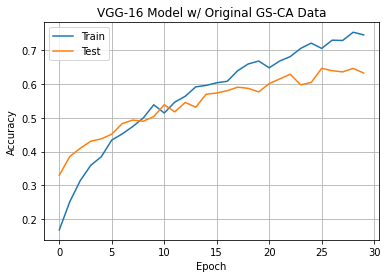

In [ ]:
plot_accuracy(model_1_hist, "VGG-16 Model w/ Original GS-CA Data")

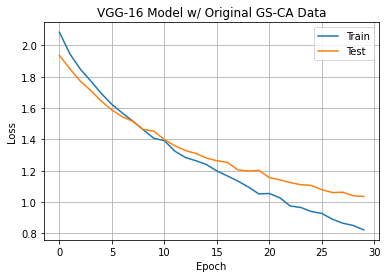

In [ ]:
plot_loss(model_1_hist, "VGG-16 Model w/ Original GS-CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 46.10960245132446 seconds 



In [ ]:
model.evaluate(vgg_test_features, y_test)

9/9 [==============================] - 1s 11ms/step - loss: 1.0355 - accuracy: 0.6319


[1.035460114479065, 0.631944477558136]

In [ ]:
y_pred_model_1 = get_predictions(vgg_test_features, model, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.73      0.63      0.68        35
        Calm       0.70      0.78      0.74        36
     Disgust       0.73      0.69      0.71        39
        Fear       0.94      0.40      0.56        40
       Happy       0.50      0.67      0.57        36
     Neutral       0.60      0.38      0.46        24
         Sad       0.39      0.58      0.46        38
    Surprise       0.77      0.85      0.81        40

    accuracy                           0.63       288
   macro avg       0.67      0.62      0.62       288
weighted avg       0.68      0.63      0.63       288



In [ ]:
model.save("/content/drive/My Drive/Thesis/RAVDESS/VGG16_Orig_GS-CA_Data.h5")

# VGG-19 Deployment as Feature Extractor
---

In [ ]:
def create_model():
  vgg_19 = vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg_19.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_19_model = Model(vgg_19.input, output)

  vgg_19_model.trainable = False

  for layer in vgg_19_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_19_model.output_shape[1]

  vgg_19_train_features = get_bneck_features(vgg_19_model, train_dataset)
  vgg_19_test_features = get_bneck_features(vgg_19_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, vgg_19_train_features, vgg_19_test_features

with tpu_strategy.scope():
  model_3, vgg_19_train_features, vgg_19_test_features = create_model()
  model_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_3.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               15729152  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
Total params: 15,995,912
Trainable params: 15,995,912
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("Training Set Bottleneck Features:", vgg_19_train_features.shape)
print("Test Set Bottleneck Features:", vgg_19_test_features.shape)

Training Set Bottleneck Features: (1152, 30720)
Test Set Bottleneck Features: (288, 30720)


In [ ]:
start_time_model_3 = time.time()

model_3_hist = model_3.fit(x = vgg_19_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (vgg_19_test_features, y_test), verbose = 1)

end_time_model_3 = time.time()

Epoch 1/30
36/36 [==============================] - 7s 65ms/step - loss: 2.0901 - accuracy: 0.1719 - val_loss: 1.9333 - val_accuracy: 0.3160
Epoch 2/30
36/36 [==============================] - 1s 34ms/step - loss: 1.9506 - accuracy: 0.2561 - val_loss: 1.8570 - val_accuracy: 0.3472
Epoch 3/30
36/36 [==============================] - 1s 33ms/step - loss: 1.8828 - accuracy: 0.2882 - val_loss: 1.8071 - val_accuracy: 0.3611
Epoch 4/30
36/36 [==============================] - 1s 34ms/step - loss: 1.7841 - accuracy: 0.3481 - val_loss: 1.7378 - val_accuracy: 0.3715
Epoch 5/30
36/36 [==============================] - 1s 34ms/step - loss: 1.7005 - accuracy: 0.3967 - val_loss: 1.6862 - val_accuracy: 0.4410
Epoch 6/30
36/36 [==============================] - 1s 35ms/step - loss: 1.6695 - accuracy: 0.4097 - val_loss: 1.6276 - val_accuracy: 0.4618
Epoch 7/30
36/36 [==============================] - 1s 34ms/step - loss: 1.5833 - accuracy: 0.4349 - val_loss: 1.6187 - val_accuracy: 0.4097
Epoch 8/30
36

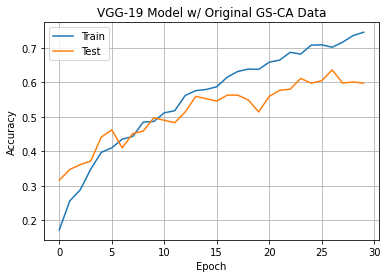

In [ ]:
plot_accuracy(model_3_hist, "VGG-19 Model w/ Original GS-CA Data")

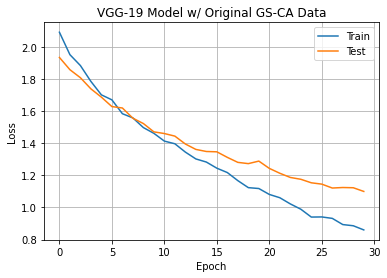

In [ ]:
plot_loss(model_3_hist, "VGG-19 Model w/ Original GS-CA Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_3 - start_time_model_3), "\n")

Elapsed Training Time: 45.70239520072937 seconds 



In [ ]:
model_3.evaluate(vgg_19_test_features, y_test)

9/9 [==============================] - 1s 10ms/step - loss: 1.0996 - accuracy: 0.5972


[1.0996267795562744, 0.5972222089767456]

In [ ]:
y_pred_model_3 = get_predictions(vgg_19_test_features, model_3, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_3, encoder)

              precision    recall  f1-score   support

       Angry       0.67      0.51      0.58        35
        Calm       0.57      0.92      0.70        36
     Disgust       0.65      0.67      0.66        39
        Fear       0.68      0.42      0.52        40
       Happy       0.50      0.50      0.50        36
     Neutral       0.67      0.25      0.36        24
         Sad       0.45      0.47      0.46        38
    Surprise       0.68      0.90      0.77        40

    accuracy                           0.60       288
   macro avg       0.61      0.58      0.57       288
weighted avg       0.61      0.60      0.58       288



In [ ]:
model_3.save("/content/drive/My Drive/Thesis/RAVDESS/VGG19_GS-CA_Orig_Data.h5")

# InceptionV3 Deployment as Feature Extractor
---

In [ ]:
def create_model():
  inception = InceptionV3(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = inception.layers[-1].output
  output = Flatten()(output)
  inception_model = Model(inception.input, output)

  inception_model.trainable = False

  for layer in inception_model.layers:
    layer.trainable = False
  
  model = Sequential()
  input_shape = inception_model.output_shape[1]

  inception_train_features = get_bneck_features(inception_model, train_dataset)
  inception_test_features = get_bneck_features(inception_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, inception_train_features, inception_test_features

with tpu_strategy.scope():
  model_4, inception_train_features, inception_test_features = create_model()
  model_4.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_4.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               47186432  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 4104      
Total params: 47,453,192
Trainable params: 47,453,192
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_4 = time.time()

model_4_hist = model_4.fit(x = inception_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (inception_test_features, y_test), verbose = 1)

end_time_model_4 = time.time()

Epoch 1/30
36/36 [==============================] - 7s 95ms/step - loss: 2.0863 - accuracy: 0.2587 - val_loss: 1.6794 - val_accuracy: 0.4236
Epoch 2/30
36/36 [==============================] - 2s 43ms/step - loss: 1.6168 - accuracy: 0.4045 - val_loss: 1.5015 - val_accuracy: 0.4688
Epoch 3/30
36/36 [==============================] - 2s 43ms/step - loss: 1.4086 - accuracy: 0.4948 - val_loss: 1.4239 - val_accuracy: 0.4722
Epoch 4/30
36/36 [==============================] - 3s 75ms/step - loss: 1.2372 - accuracy: 0.5703 - val_loss: 1.4360 - val_accuracy: 0.4618
Epoch 5/30
36/36 [==============================] - 2s 44ms/step - loss: 1.0849 - accuracy: 0.6189 - val_loss: 1.2959 - val_accuracy: 0.5035
Epoch 6/30
36/36 [==============================] - 2s 43ms/step - loss: 0.9616 - accuracy: 0.6562 - val_loss: 1.3239 - val_accuracy: 0.5174
Epoch 7/30
36/36 [==============================] - 2s 44ms/step - loss: 0.8389 - accuracy: 0.7118 - val_loss: 1.2453 - val_accuracy: 0.5347
Epoch 8/30
36

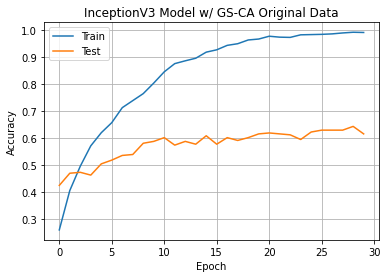

In [ ]:
plot_accuracy(model_4_hist, "InceptionV3 Model w/ GS-CA Original Data")

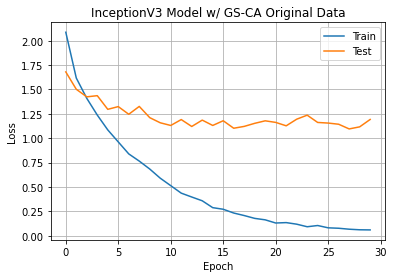

In [ ]:
plot_loss(model_4_hist, "InceptionV3 Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_4 - start_time_model_4), "\n")

Elapsed Training Time: 59.35582447052002 seconds 



In [ ]:
model_4.evaluate(inception_test_features, y_test)

9/9 [==============================] - 1s 11ms/step - loss: 1.1920 - accuracy: 0.6146


[1.1920140981674194, 0.6145833134651184]

In [ ]:
y_pred_model_4 = get_predictions(inception_test_features, model_4, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_4, encoder)

              precision    recall  f1-score   support

       Angry       0.62      0.66      0.64        35
        Calm       0.50      0.92      0.65        36
     Disgust       0.70      0.67      0.68        39
        Fear       0.81      0.53      0.64        40
       Happy       0.51      0.50      0.51        36
     Neutral       0.62      0.42      0.50        24
         Sad       0.55      0.32      0.40        38
    Surprise       0.69      0.85      0.76        40

    accuracy                           0.61       288
   macro avg       0.63      0.61      0.60       288
weighted avg       0.63      0.61      0.60       288



In [ ]:
model_4.save("/content/drive/My Drive/Thesis/RAVDESS/InceptionV3_GS-CA_Orig_Data.h5")

# Xception Deployment as Feature Extractor
---

In [ ]:
def create_model():
  xception = Xception(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = xception.layers[-1].output
  output = Flatten()(output)
  xception_model = Model(xception.input, output)

  xception_model.trainable = False
  
  model = Sequential()
  input_shape = xception_model.output_shape[1]

  xception_train_features = get_bneck_features(xception_model, train_dataset)
  xception_test_features = get_bneck_features(xception_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, xception_train_features, xception_test_features

with tpu_strategy.scope():
  model_5, xception_train_features, xception_test_features = create_model()
  model_5.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_5.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               80740864  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 4104      
Total params: 81,007,624
Trainable params: 81,007,624
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("Training Set Bottleneck Features:", xception_train_features.shape)
print("Test Set Bottleneck Features:", xception_test_features.shape)

Training Set Bottleneck Features: (1152, 157696)
Test Set Bottleneck Features: (288, 157696)


In [ ]:
start_time_model_5 = time.time()

model_5_hist = model_5.fit(x = xception_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (xception_test_features, y_test), verbose = 1)

end_time_model_5 = time.time()

Epoch 1/30
36/36 [==============================] - 10s 121ms/step - loss: 1.8408 - accuracy: 0.2995 - val_loss: 1.4983 - val_accuracy: 0.4792
Epoch 2/30
36/36 [==============================] - 2s 48ms/step - loss: 1.4713 - accuracy: 0.4748 - val_loss: 1.3063 - val_accuracy: 0.5278
Epoch 3/30
36/36 [==============================] - 2s 49ms/step - loss: 1.2978 - accuracy: 0.5339 - val_loss: 1.2459 - val_accuracy: 0.5347
Epoch 4/30
36/36 [==============================] - 2s 48ms/step - loss: 1.1215 - accuracy: 0.5972 - val_loss: 1.1734 - val_accuracy: 0.5660
Epoch 5/30
36/36 [==============================] - 2s 48ms/step - loss: 0.9999 - accuracy: 0.6345 - val_loss: 1.0723 - val_accuracy: 0.5972
Epoch 6/30
36/36 [==============================] - 2s 68ms/step - loss: 0.9143 - accuracy: 0.6858 - val_loss: 1.1180 - val_accuracy: 0.5938
Epoch 7/30
36/36 [==============================] - 2s 48ms/step - loss: 0.7743 - accuracy: 0.7326 - val_loss: 1.0538 - val_accuracy: 0.6007
Epoch 8/30


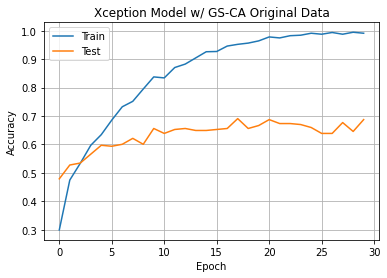

In [ ]:
plot_accuracy(model_5_hist, "Xception Model w/ GS-CA Original Data")

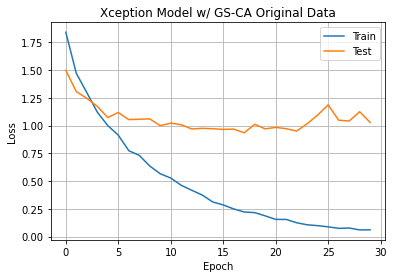

In [ ]:
plot_loss(model_5_hist, "Xception Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_5 - start_time_model_5), "\n")

Elapsed Training Time: 71.74183797836304 seconds 



In [ ]:
model_5.evaluate(xception_test_features, y_test)

9/9 [==============================] - 1s 10ms/step - loss: 1.0285 - accuracy: 0.6875


[1.0285441875457764, 0.6875]

In [ ]:
y_pred_model_5 = get_predictions(xception_test_features, model_5, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_5, encoder)

              precision    recall  f1-score   support

       Angry       0.62      0.51      0.56        35
        Calm       0.76      0.81      0.78        36
     Disgust       0.74      0.67      0.70        39
        Fear       0.74      0.62      0.68        40
       Happy       0.62      0.72      0.67        36
     Neutral       0.67      0.58      0.62        24
         Sad       0.61      0.66      0.63        38
    Surprise       0.73      0.88      0.80        40

    accuracy                           0.69       288
   macro avg       0.69      0.68      0.68       288
weighted avg       0.69      0.69      0.68       288



In [ ]:
model_5.save("/content/drive/My Drive/Thesis/RAVDESS/Xception_GS-CA_Orig_Data.h5")

# ResNet-50 Deployment as Feature Extractor
---

In [ ]:
def create_model():
  resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = resnet.layers[-1].output
  output = Flatten()(output)
  resnet_model = Model(resnet.input, output)

  resnet_model.trainable = False

  model = Sequential()
  input_shape = resnet_model.output_shape[1]

  resnet_train_features = get_bneck_features(resnet_model, train_dataset)
  resnet_test_features = get_bneck_features(resnet_model, test_dataset)

  model.add(InputLayer(input_shape = (input_shape,)))
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model, resnet_train_features, resnet_test_features

with tpu_strategy.scope():
  model_6, resnet_train_features, resnet_test_features = create_model()
  model_6.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_6.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               80740864  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 4104      
Total params: 81,007,624
Trainable params: 81,007,624
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("Training Set Bottleneck Features:", resnet_train_features.shape)
print("Test Set Bottleneck Features:", resnet_test_features.shape)

Training Set Bottleneck Features: (1152, 157696)
Test Set Bottleneck Features: (288, 157696)


In [ ]:
start_time_model_6 = time.time()

model_6_hist = model_6.fit(x = resnet_train_features, y = y_train, batch_size = 32, epochs = 30, validation_data = (resnet_test_features, y_test), verbose = 1)

end_time_model_6 = time.time()

Epoch 1/30
36/36 [==============================] - 10s 120ms/step - loss: 2.2758 - accuracy: 0.1484 - val_loss: 1.9679 - val_accuracy: 0.2569
Epoch 2/30
36/36 [==============================] - 2s 48ms/step - loss: 2.0240 - accuracy: 0.2144 - val_loss: 1.9366 - val_accuracy: 0.2118
Epoch 3/30
36/36 [==============================] - 2s 48ms/step - loss: 1.9913 - accuracy: 0.2057 - val_loss: 1.9172 - val_accuracy: 0.2674
Epoch 4/30
36/36 [==============================] - 3s 74ms/step - loss: 1.9301 - accuracy: 0.2491 - val_loss: 1.8856 - val_accuracy: 0.2743
Epoch 5/30
36/36 [==============================] - 2s 48ms/step - loss: 1.9115 - accuracy: 0.2665 - val_loss: 1.8427 - val_accuracy: 0.3160
Epoch 6/30
36/36 [==============================] - 2s 48ms/step - loss: 1.8681 - accuracy: 0.2830 - val_loss: 1.8242 - val_accuracy: 0.3958
Epoch 7/30
36/36 [==============================] - 2s 49ms/step - loss: 1.8448 - accuracy: 0.3056 - val_loss: 1.7931 - val_accuracy: 0.3472
Epoch 8/30


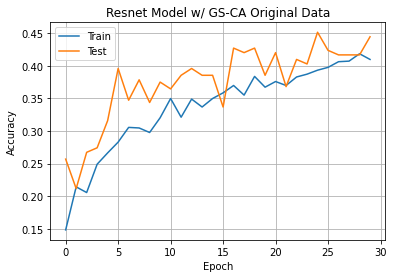

In [ ]:
plot_accuracy(model_6_hist, "Resnet Model w/ GS-CA Original Data")

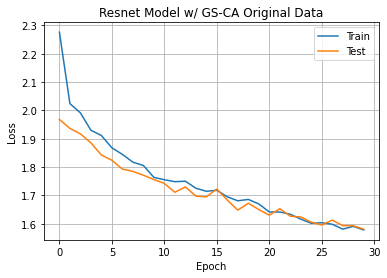

In [ ]:
plot_loss(model_6_hist, "Resnet Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_6 - start_time_model_6), "\n")

Elapsed Training Time: 71.5890302658081 seconds 



In [ ]:
model_6.evaluate(resnet_test_features, y_test)

9/9 [==============================] - 1s 11ms/step - loss: 1.5810 - accuracy: 0.4444


[1.581034541130066, 0.4444444477558136]

In [ ]:
y_pred_model_6 = get_predictions(resnet_test_features, model_6, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_6, encoder)

              precision    recall  f1-score   support

       Angry       0.39      0.69      0.50        35
        Calm       0.71      0.69      0.70        36
     Disgust       0.54      0.69      0.61        39
        Fear       0.57      0.33      0.41        40
       Happy       0.30      0.08      0.13        36
     Neutral       0.00      0.00      0.00        24
         Sad       0.28      0.18      0.22        38
    Surprise       0.35      0.72      0.47        40

    accuracy                           0.44       288
   macro avg       0.39      0.42      0.38       288
weighted avg       0.41      0.44      0.40       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_6.save("/content/drive/My Drive/Thesis/RAVDESS/Resnet_GS-CA_Orig_Data.h5")

# AlexNet
---


In [ ]:
def create_model():
  #Instantiation
  AlexNet = Sequential()

  #1st Convolutional Layer
  AlexNet.add(Conv2D(filters = 96, input_shape = input_shape_orig, kernel_size = (11,11), strides = (4, 4), padding = "same"))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))

  #2nd Convolutional Layer
  AlexNet.add(Conv2D(filters = 256, kernel_size = (5, 5), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #3rd Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #4th Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #5th Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #Passing it to a Fully Connected layer
  AlexNet.add(Flatten())
  # 1st Fully Connected Layer
  AlexNet.add(Dense(512, input_shape=input_shape_orig))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  AlexNet.add(Dropout(0.4))

  #2nd Fully Connected Layer
  AlexNet.add(Dense(512))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #3rd Fully Connected Layer
  AlexNet.add(Dense(256))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #Output Layer
  AlexNet.add(Dense(8))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('softmax'))

  return AlexNet

In [ ]:
with tpu_strategy.scope():
  AlexNet = create_model()
  AlexNet.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
  
AlexNet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 55, 84, 96)        34944     
_________________________________________________________________
batch_normalization_98 (Batc (None, 55, 84, 96)        384       
_________________________________________________________________
activation_94 (Activation)   (None, 55, 84, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 42, 96)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 28, 42, 256)       614656    
_________________________________________________________________
batch_normalization_99 (Batc (None, 28, 42, 256)       1024      
_________________________________________________________________
activation_95 (Activation)   (None, 28, 42, 256)      

In [ ]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .01, patience = 3, min_lr = 1e-5) 

In [ ]:
start_time_alexnet = time.time()

alexnet_hist = AlexNet.fit(train_dataset, epochs = 30, validation_data = test_dataset, callbacks = [lrr], verbose = 1)

end_time_alexnet = time.time()

Epoch 1/30
36/36 [==============================] - 55s 957ms/step - loss: 2.2168 - accuracy: 0.1727 - val_loss: 87.2756 - val_accuracy: 0.1632
Epoch 2/30
36/36 [==============================] - 32s 894ms/step - loss: 2.0179 - accuracy: 0.2135 - val_loss: 19.3975 - val_accuracy: 0.1424
Epoch 3/30
36/36 [==============================] - 33s 920ms/step - loss: 1.9560 - accuracy: 0.2326 - val_loss: 4.4817 - val_accuracy: 0.1979
Epoch 4/30
36/36 [==============================] - 32s 897ms/step - loss: 1.9158 - accuracy: 0.2457 - val_loss: 2.2844 - val_accuracy: 0.2674
Epoch 5/30
36/36 [==============================] - 37s 1s/step - loss: 1.8655 - accuracy: 0.2795 - val_loss: 2.1748 - val_accuracy: 0.2465
Epoch 6/30
36/36 [==============================] - 43s 1s/step - loss: 1.8588 - accuracy: 0.2839 - val_loss: 1.8766 - val_accuracy: 0.2917
Epoch 7/30
36/36 [==============================] - 42s 1s/step - loss: 1.8388 - accuracy: 0.3073 - val_loss: 1.9031 - val_accuracy: 0.2778
Epoch 

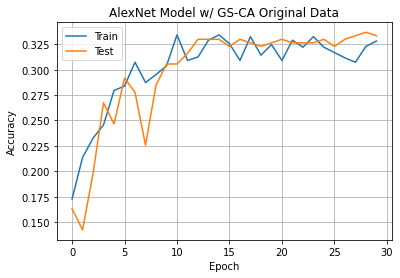

In [ ]:
plot_accuracy(alexnet_hist, "AlexNet Model w/ GS-CA Original Data")

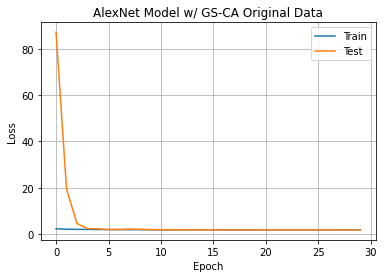

In [ ]:
plot_loss(alexnet_hist, "AlexNet Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_alexnet - start_time_alexnet), "\n")

Elapsed Training Time: 1047.955266237259 seconds 



In [ ]:
AlexNet.evaluate(test_dataset)

9/9 [==============================] - 8s 693ms/step - loss: 1.7128 - accuracy: 0.3333


[1.712750792503357, 0.3333333432674408]

In [ ]:
y_pred_alexnet = get_predictions(test_dataset, AlexNet, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_alexnet, encoder)

              precision    recall  f1-score   support

       Angry       0.46      0.51      0.49        35
        Calm       0.39      0.53      0.45        36
     Disgust       0.35      0.46      0.40        39
        Fear       0.47      0.17      0.25        40
       Happy       0.44      0.19      0.27        36
     Neutral       0.00      0.00      0.00        24
         Sad       0.16      0.29      0.20        38
    Surprise       0.34      0.40      0.37        40

    accuracy                           0.33       288
   macro avg       0.32      0.32      0.30       288
weighted avg       0.34      0.33      0.32       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
AlexNet.save("/content/drive/My Drive/Thesis/RAVDESS/AlexNet_GS-CA_Orig_Data.h5")